In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty, plot_covariate_panel

%load_ext autoreload
%autoreload 2

#load published mouse clocks
clocks = pickle.load(open('subdata/clock_coefs_mouse.pkl', 'rb'))

# GSE120132 -> GSE60334 (Mouse embryogenesis)

In [2]:
#Aging (Thompson + Meer)
dfa, meta = pickle.load(open('datasets/GSE120132_GSE121141.pkl', 'rb')).values()
dfa = dfa[meta.index].T

#Embryogenesis
dfr, metr = pickle.load(open('datasets/GSE60334.pkl', 'rb')).values()
#filtering & processing (Preserve only samples as in Kerepesi, 2019)
metr = metr[metr['DayEmbryo'] != 'Adult'] 
metr = metr[metr['Genotype'] == 'WT']
metr['Age'] = [float(e.split('E')[1]) for e in metr['DayEmbryo'].values]
dfr = dfr.loc[metr.index]

tissue_age = 'Blood' #only Thompson dataset contains blood samples from mice
if tissue_age is not None:
    meta = meta[meta['Tissue'] == tissue_age]
    dfa = dfa.loc[meta.index].dropna(axis=1)

print('Age, N sites', len(dfa.columns))
print('Rep, N sites', len(dfr.columns))

# Thompson clock sites
clock = clocks['Thompson']

Age, N sites 934041
Rep, N sites 862533


## Check covariate shift

In [7]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

#conduct PCA on joined dataset
pca = PCA(2)
pca.fit(pd.concat([Xa_clock, Xr_clock]))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

348 common sites


85.34% of sites are not rejected by KS test


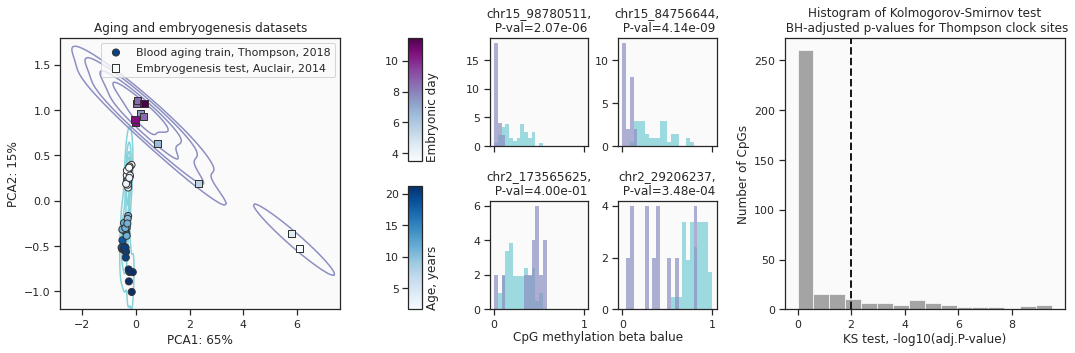

In [8]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'BuPu',
                        color_train = '#86d2da',
                        color_test = '#8c8ec1',
                        xa_thr = 0.05,
                        xr_thr = 0.25,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Embryonic day',
                        legend_label_train = 'Blood aging train, Thompson, 2018',
                        legend_label_test = 'Embryogenesis test, Auclair, 2014',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Thompson clock sites',
                        pca_title = 'Aging and embryogenesis datasets',
                        pca_legend_pos = 'upper right',
                        pca_xlim = [-2.8, 7.6],
                        pca_ylim = [-1.2, 1.8]                   
                        )

plt.savefig('figs/A1_sup_embryo.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [9]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

348 common sites


Step 1 results:
R2 train = 0.988
MAE train = 0.641
R2 test = 0.909
MAE test = 2.001
------------------------------
Step 2 results:
R2 train = 0.9
MAE train = 2.179
R2 test = 0.841
MAE test = 2.285
------------------------------


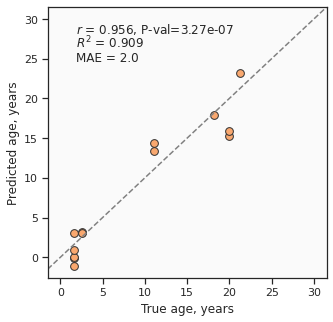

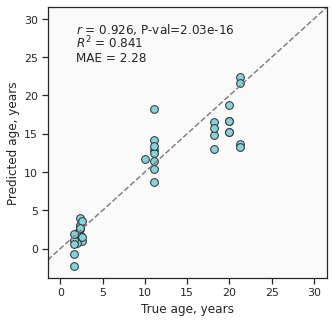

In [10]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_test, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60)
plt.savefig('figs/A3_aging_blood_train_test_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_blood_train_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 0.999
MAE train = 0.152
------------------------------
Step 2 results:
R2 test = -2.262
MAE test = 12.796
------------------------------


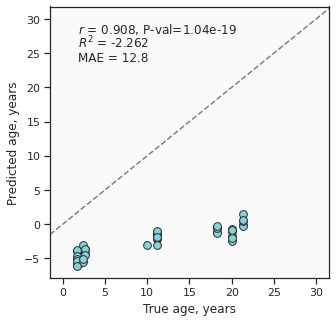

In [11]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_blood_train_embryo_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

348 common sites
R2 train = 0.9999760566360258
R2 test = 0.9356960785025242
MAE train = 0.03015390422093306
MAE test = 1.732961236706602
------------------------------
Resulting kernel: 16.2**2 * RBF(length_scale=3.99) + WhiteKernel(noise_level=0.1)
Resulting kernel (full): 11.6**2 * RBF(length_scale=2.81) + WhiteKernel(noise_level=0.1)


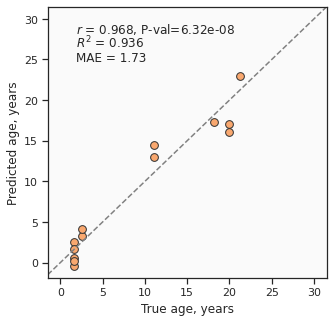

In [12]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60)
plt.savefig('figs/A4_sup_GP_blood_test_performance.pdf', format='pdf', bbox_inches='tight')

model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(Xa_clock, ya)
print("Resulting kernel (full):", model.kernel_)

Avg uncertainty std: 5.4733789743184715
P-value of rejuvenation effect between 3.5 and 8.5 days is 0.5436804989351152
P-value of rejuvenation effect between 8.5 and 10.5 days is 0.37603291384412263
P-value of rejuvenation effect between 10.5 and 11.5 days is 0.7156747480746344


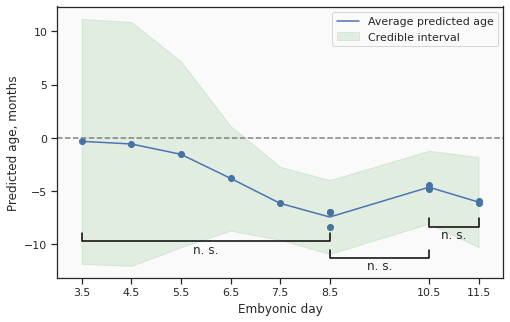

In [13]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr.values, y_test_predict_r, y_test_std_r, 
                      days=[(3.5, 8.5), (8.5, 10.5), (10.5, 11.5)],
                      nstd=1, dh=[0.06, 0.12, 0.06], barh=0.03,
                      ylabel='Predicted age, months',
                      xlabel='Embyonic day'
                      )

plt.savefig('figs/A4_embryo_trajectory.pdf', format='pdf', bbox_inches='tight')

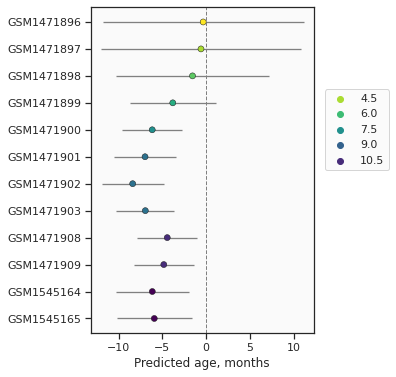

R2 test = -27.09336684995247
MAE test = 12.748917512861935


In [14]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr['gpr_age'] = y_test_predict_r
metr['gpr_std'] = y_test_std_r
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
metr_ = metr.copy().reset_index().sort_values('Age')


ax.errorbar(x=metr_['gpr_age'], y=metr_['index'], xerr=metr_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')

sns.scatterplot(
    data=metr_, x="gpr_age", y='index',  
    marker="o",
    hue='Age',
    edgecolor='k',
    palette=mpl.cm.viridis_r,
    zorder=2,
    ax=ax
)

ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted age, months')
ax.set_ylabel('')
ax.legend(loc=[1.05, 0.5])
plt.show()

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')